<a href="https://colab.research.google.com/github/anitamezzetti/financial_big_data/blob/main/granger_causality_many_cuntries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
student1 = "Anita Mezzetti"
student2 = "Hien Lê"

Complementary stuff:
* Drive Folder to save data, notebooks and models

Note: project has been linked to [Github](https://github.com/anitamezzetti/financial_big_data)!

In [ ]:
from google.colab import drive
import os, sys

drive.mount('/content/drive')
#nb_path = '/content/notebooks2'
#os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
#sys.path.insert(0,nb_path)

#!pip install --target=$nb_path arrow

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks" # checking the content of the folder

 AnitaVersion_FinBigData_1.ipynb
 arrow
 arrow-0.17.0.dist-info
 AUS.csv
 AUT.csv
 BEL.csv
 BRA.csv
 CAN.csv
 CHE.csv
 CHN.csv
 classification_3.ipynb
'classification_4 (1).ipynb'
 classification_4.ipynb
 classification.ipynb
 closed_form_solution.ipynb
'complete_mc (1).ipynb'
'complete_mc (2).ipynb'
 complete_mc.ipynb
'Copia di mc.ipynb'
 CZE.csv
 dateutil
 DEU.csv
 DNK.csv
 ESP.csv
 FIN.csv
 FRA.csv
 GBR.csv
 generate_dataset_dataset4.ipynb
 generate_dataset_fixedK_movingS0.ipynb
 generate_dataset.ipynb
 GHA.csv
'granger_causality_covid (1).ipynb'
 granger_causality_covid.ipynb
 granger_causality_japan.ipynb
'granger_causality_many_cuntries (1).ipynb'
 granger_causality_many_cuntries.ipynb
 GRC.csv
'Heston_Project (1).ipynb'
'Heston_Project (2).ipynb'
 Heston_Project.ipynb
 HienCovidDataRetrieval.ipynb
 HRV.csv
 IRL.csv
 ITA.csv
 JPN.csv
 NLD.csv
 notebooks2
 NZL.csv
 POL.csv
 PRT.csv
 __pycache__
 python_dateutil-2.8.1.dist-info
 RUS.csv
 six-1.15.0.dist-info
 six.py
 SWE.csv
 THA.c

In [ ]:
root = "/content/drive/My Drive/Colab Notebooks" 

In [ ]:
!pip install arrow

In [ ]:
!pip install ipynb

## Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipynb 
import os.path
import statsmodels.api as sm


# other libraries here
import requests
import arrow

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Import functions for granger causality

In [ ]:
from granger_causality_functions import scale_data, plot_time_series, plot_correlation_matrix, make_stationary
from granger_causality_functions import grangers_causality_matrix, network_granger, granger_causality

In [ ]:
# list of countries of interest

countries_of_interest = ["USA", "CHE", "JPN", "CHN"]

countries_of_interest_world = ["USA", "CHE", "JPN", "CHN", "ITA", "FRA", "CAN", "ESP", 
                               "BRA", "AUS", "NZL", "RUS", "GBR", "GHA", "THA", "DEU"]

countries_of_interest_eu =    ["AUT", "BEL", "HRV", "DNK", "FIN", "FRA", "DEU", "IRL", 
                               "ITA", "NLD", "POL", "PRT", "ESP", "SWE", "GBR"]

# Granger Causality World View

In [ ]:
endpoint = "https://covidapi.info/api/v1" # endpoint that provides JHU data
start_date = "2020-01-01"
end_date = "2020-12-01" # yesterday
dfs_world = {} # dfs of cumulative confirmed cases
for country in countries_of_interest_world:

    # re-download only data for country still not seen
    if os.path.isfile(f"data_covid/{country}.csv"):
        df = pd.read_csv(f"data_covid/{country}.csv")
    else:
        query = f"{endpoint}/country/{country}/timeseries/{start_date}/{end_date}"
        res = requests.get(query).json()
        df = pd.DataFrame(res["result"])
        df.index = pd.DatetimeIndex(df["date"], tz="utc")
        df.drop(columns=["date"])
        df["date"] = pd.to_datetime(df["date"])
        df["ts_in_secs"] = df["date"].astype(int)
        df["new_confirmed"] = df["confirmed"].diff().fillna(0)
        df.to_csv(f"{root}/{country}.csv")
        
    dfs_world[country] = df

## Analysis

In [ ]:
# dataset for confirmed cases for each country (needed later)
df_confirmed_world = pd.DataFrame(index = dfs_world[country].index)
df_total_world = pd.DataFrame(index = dfs_world[country].index)

In [ ]:
# first overview
for country,df in dfs_world.items():  
    df_confirmed_world[country] = df["new_confirmed"] 
    df_total_world[country] = df["confirmed"]

## Study New Cases

Normalize data

In [ ]:
df_confirmed_scaled_world = scale_data(df_total_world, countries_of_interest_world)
df_confirmed_scaled_world.head()

,USA,CHE,JPN,CHN,ITA,FRA,CAN,ESP,BRA,AUS,NZL,RUS,GBR,GHA,THA,DEU
date,,,,,,,,,,,,,,,,
2020-01-22 00:00:00+00:00,7.353214e-08,0.0,1.470643e-07,0.000040,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,1.470643e-07,0.0
2020-01-23 00:00:00+00:00,7.353214e-08,0.0,1.470643e-07,0.000047,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,2.205964e-07,0.0
2020-01-24 00:00:00+00:00,1.470643e-07,0.0,1.470643e-07,0.000068,0.0,1.470643e-07,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,3.676607e-07,0.0
2020-01-25 00:00:00+00:00,1.470643e-07,0.0,1.470643e-07,0.000103,0.0,2.205964e-07,0.000000e+00,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,5.147250e-07,0.0
2020-01-26 00:00:00+00:00,3.676607e-07,0.0,2.941285e-07,0.000153,0.0,2.205964e-07,7.353214e-08,0.0,0.0,2.941285e-07,0.0,0.0,0.0,0.0,5.882571e-07,0.0


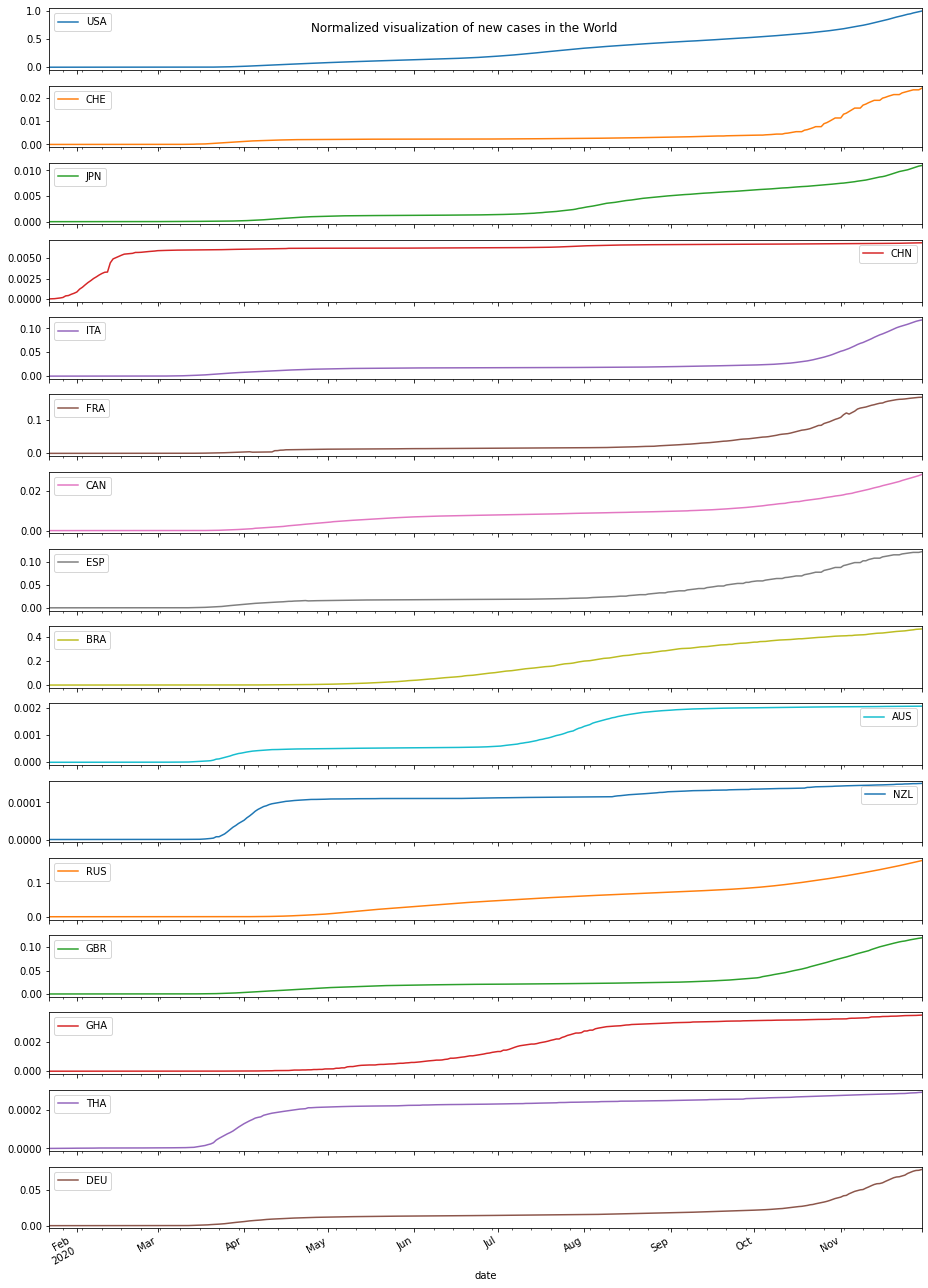

In [ ]:
plot_time_series(df_confirmed_scaled_world, 'Normalized visualization of new cases in the World')

### Correlation matrix of new cases among different countries

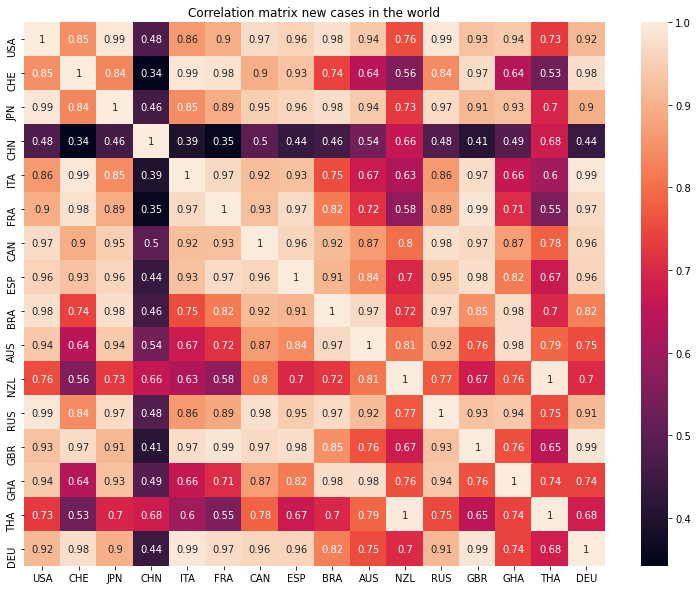

In [ ]:
plot_correlation_matrix(df_confirmed_scaled_world, countries_of_interest_world, 'Correlation matrix new cases in the world')

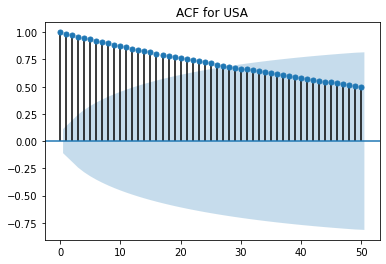

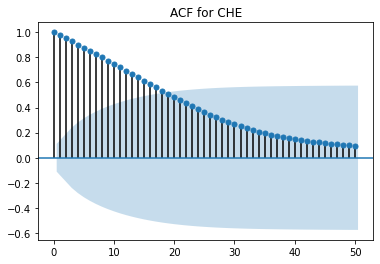

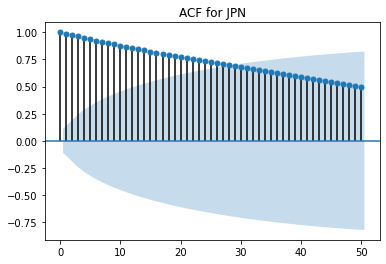

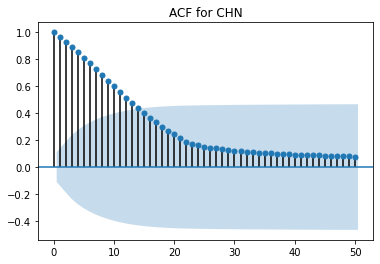

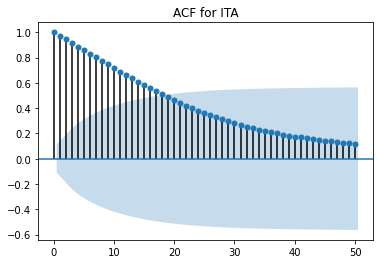

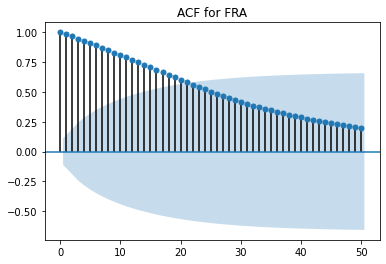

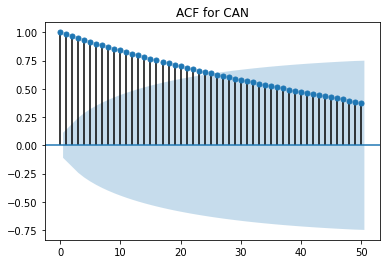

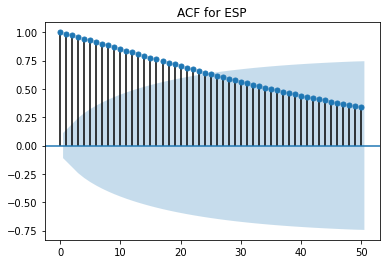

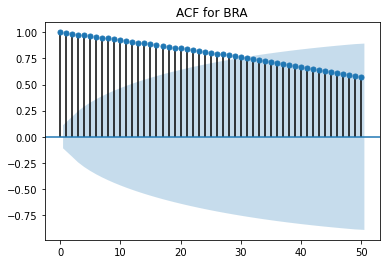

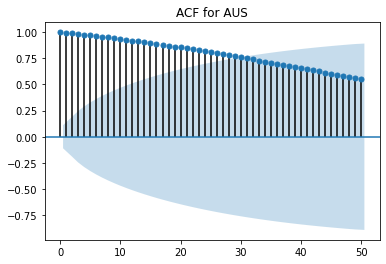

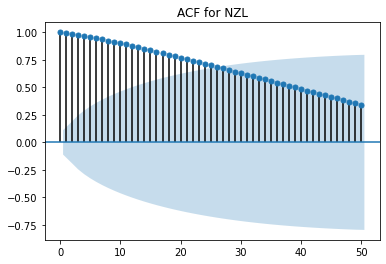

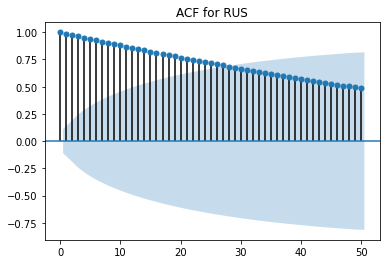

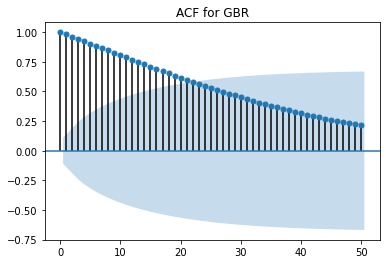

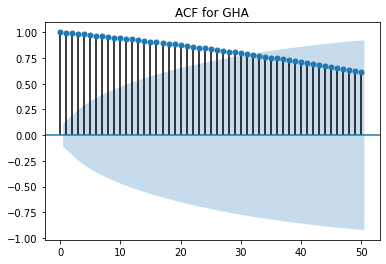

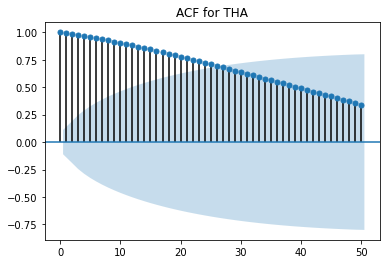

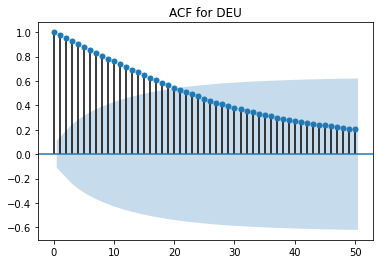

In [ ]:
for country in df_confirmed_scaled_world:
    sm.graphics.tsa.plot_acf(df_confirmed_scaled_world[country], lags = 50)
    plt.title('ACF for %s' % country)
    plt.show()

STATIONARY TEST: 

 Dickey-Fuller Stationary Test for "USA" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = 3.2176
 No. Lags Chosen      = 16
 Critical value 1%     = -3.453
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 1.0. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "CHE" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = 4.5934
 No. Lags Chosen      = 15
 Critical value 1%     = -3.452
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 1.0. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "JPN" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = 2.87

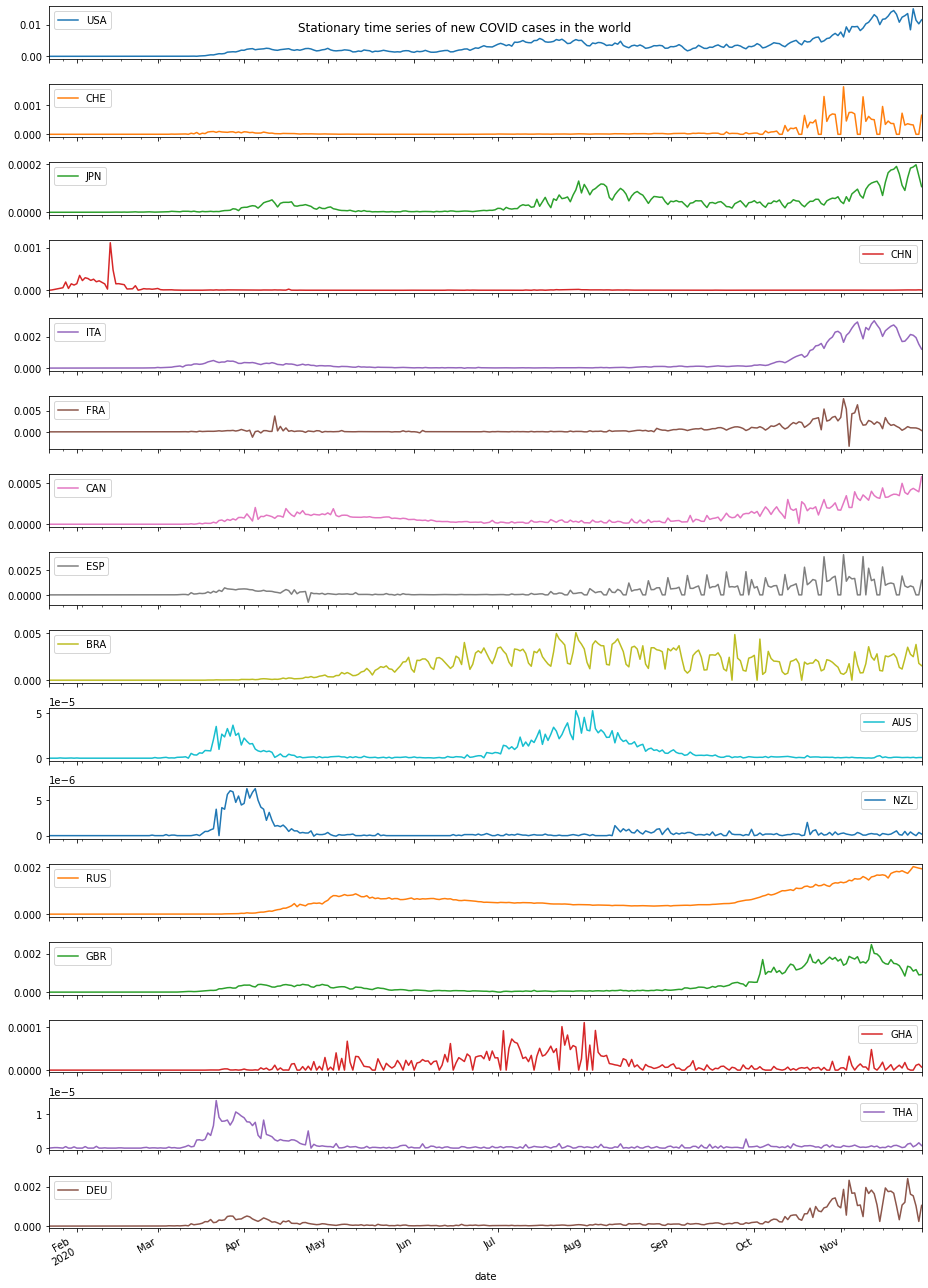


GRANGER CAUSALITY MATRIX: 



,USA_x,CHE_x,JPN_x,CHN_x,ITA_x,FRA_x,CAN_x,ESP_x,BRA_x,AUS_x,NZL_x,RUS_x,GBR_x,GHA_x,THA_x,DEU_x
USA_y,0.0,0.0,0.0,0.568,0.0,0.0,0.0,0.0,0.0,0.337,0.248,0.0,0.0,0.523,0.584,0.0
CHE_y,0.0,0.0,0.0,0.347,0.0,0.0,0.0,0.0,0.0,0.127,0.0,0.0,0.0,0.204,0.79,0.0
JPN_y,0.0,0.0,0.0,0.57,0.0,0.0,0.0,0.0,0.0,0.0,0.548,0.0,0.0,0.0,0.844,0.0
CHN_y,0.0,0.423,0.0,0.0,0.274,0.286,0.0,0.208,0.0,0.28,0.434,0.0,0.133,0.223,0.392,0.243
ITA_y,0.0,0.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0,0.475,0.679,0.0,0.0,0.346,0.694,0.0
FRA_y,0.0,0.0,0.0,0.313,0.0,0.0,0.0,0.0,0.176,0.119,0.0,0.0,0.0,0.362,0.395,0.0
CAN_y,0.0,0.0,0.0,0.541,0.0,0.0,0.0,0.0,0.0,0.401,0.0,0.0,0.0,0.562,0.146,0.0
ESP_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.164,0.0,0.0
BRA_y,0.0,0.0,0.0,0.103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AUS_y,0.604,0.649,0.16,0.59,0.364,0.394,0.191,0.27,0.0,0.0,0.0,0.306,0.181,0.0,0.0,0.505


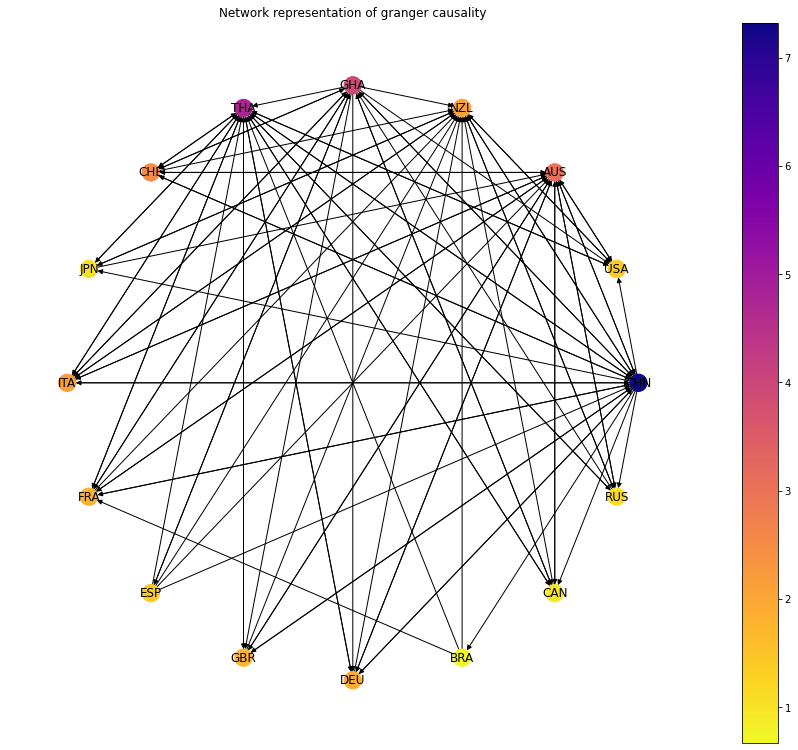

In [ ]:
granger_matrix = granger_causality(df_confirmed_scaled_world, countries_of_interest_world, 'new COVID cases in the world')

# Granger Causality EU View

In [ ]:
endpoint = "https://covidapi.info/api/v1" # endpoint that provides JHU data
start_date = "2020-01-1"
end_date = "2020-12-01" # yesterday
dfs_eu = {} # dfs of cumulative confirmed cases
for country in countries_of_interest_eu:

    # re-download only data for country still not seen
    if os.path.isfile(f"data_covid/{country}.csv"):
        df = pd.read_csv(f"data_covid/{country}.csv")
    else:
        query = f"{endpoint}/country/{country}/timeseries/{start_date}/{end_date}"
        res = requests.get(query).json()
        df = pd.DataFrame(res["result"])
        df.index = pd.DatetimeIndex(df["date"], tz="utc")
        df.drop(columns=["date"])
        df["date"] = pd.to_datetime(df["date"])
        df["ts_in_secs"] = df["date"].astype(int)
        df["new_confirmed"] = df["confirmed"].diff().fillna(0)
        df.to_csv(f"{root}/{country}.csv")
        #df.to_csv(f"data_covid/{country}.csv")
        
    dfs_eu[country] = df

## Analysis

In [ ]:
# dataset for confirmed cases for each country (needed later)
df_confirmed_eu = pd.DataFrame(index = dfs_eu[country].index)
df_total_eu = pd.DataFrame(index = dfs_eu[country].index)

In [ ]:
# first overview
for country,df in dfs_eu.items():  
    df_confirmed_eu[country] = df["new_confirmed"] 
    df_total_eu[country] = df["confirmed"]

## Study New Cases

Normalize data

In [ ]:
df_confirmed_scaled_eu = scale_data(df_total_eu, countries_of_interest_eu)
df_confirmed_scaled_eu.head()

,AUT,BEL,HRV,DNK,FIN,FRA,DEU,IRL,ITA,NLD,POL,PRT,ESP,SWE,GBR
date,,,,,,,,,,,,,,,
2020-01-22 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,8.783973e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,1.317596e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,1.317596e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


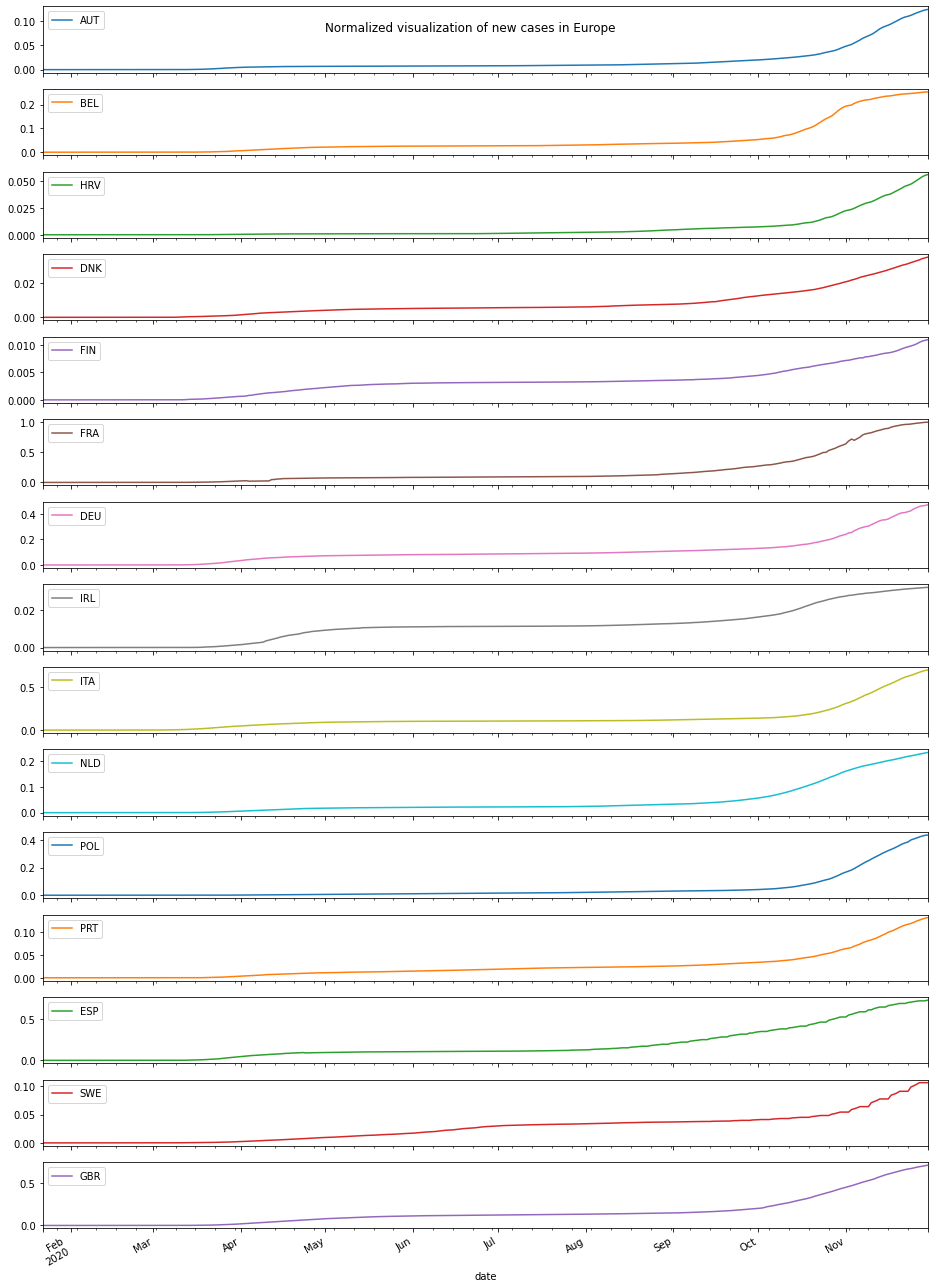

In [ ]:
plot_time_series(df_confirmed_scaled_eu, 'Normalized visualization of new cases in Europe')

### Correlation matrix of new cases among different countries

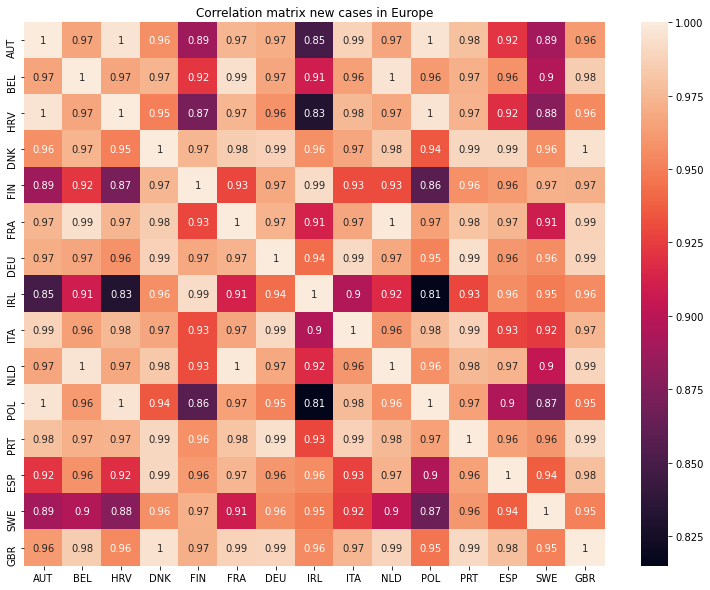

In [ ]:
plot_correlation_matrix(df_confirmed_scaled_eu, countries_of_interest_eu, 'Correlation matrix new cases in Europe')

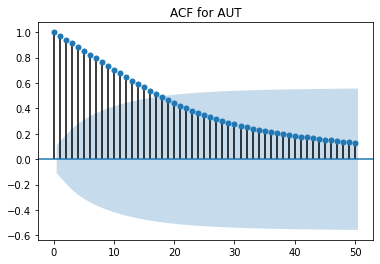

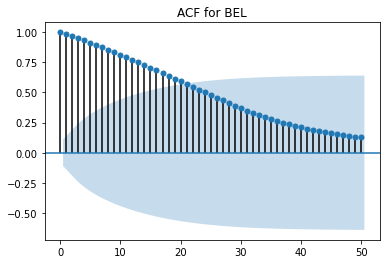

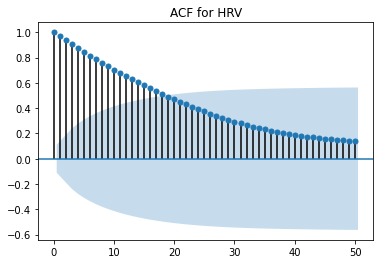

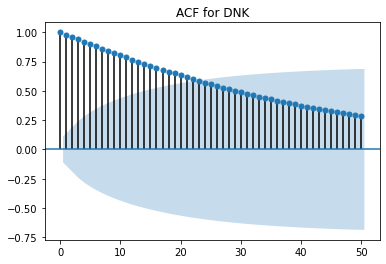

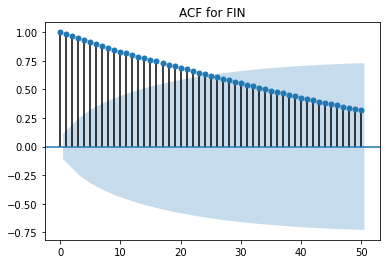

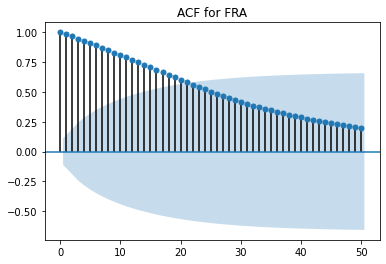

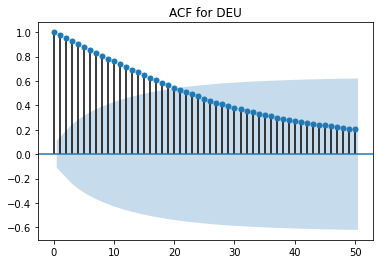

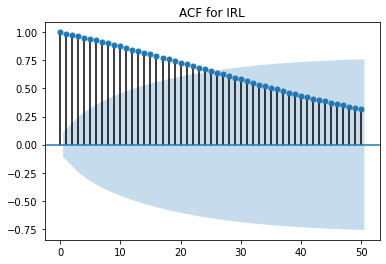

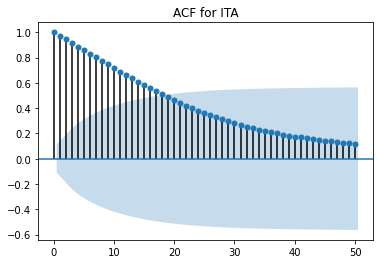

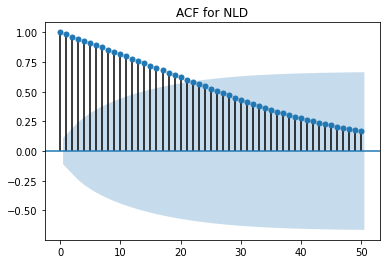

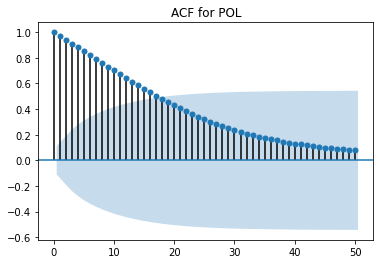

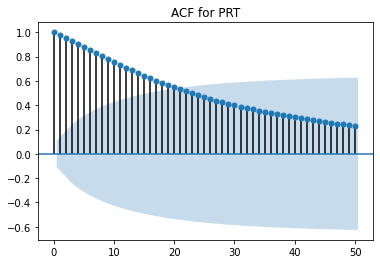

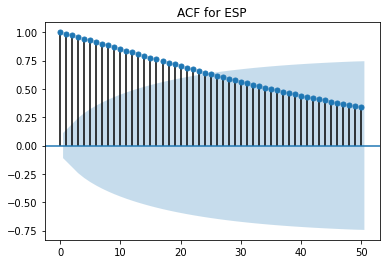

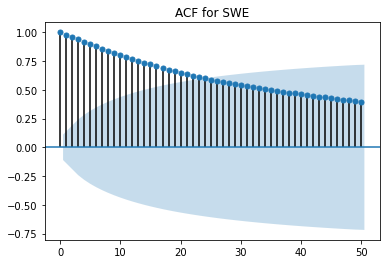

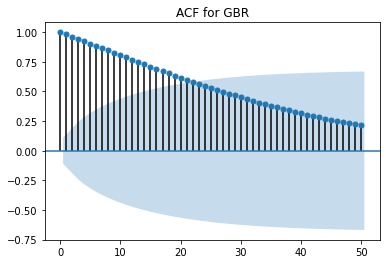

In [ ]:
for country in df_confirmed_scaled_eu:
    sm.graphics.tsa.plot_acf(df_confirmed_scaled_eu[country], lags = 50)
    plt.title('ACF for %s' % country)
    plt.show()

STATIONARY TEST: 

 Dickey-Fuller Stationary Test for "AUT" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = 4.1535
 No. Lags Chosen      = 15
 Critical value 1%     = -3.452
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 1.0. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "BEL" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = 0.4112
 No. Lags Chosen      = 16
 Critical value 1%     = -3.453
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.9819. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "HRV" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = 1

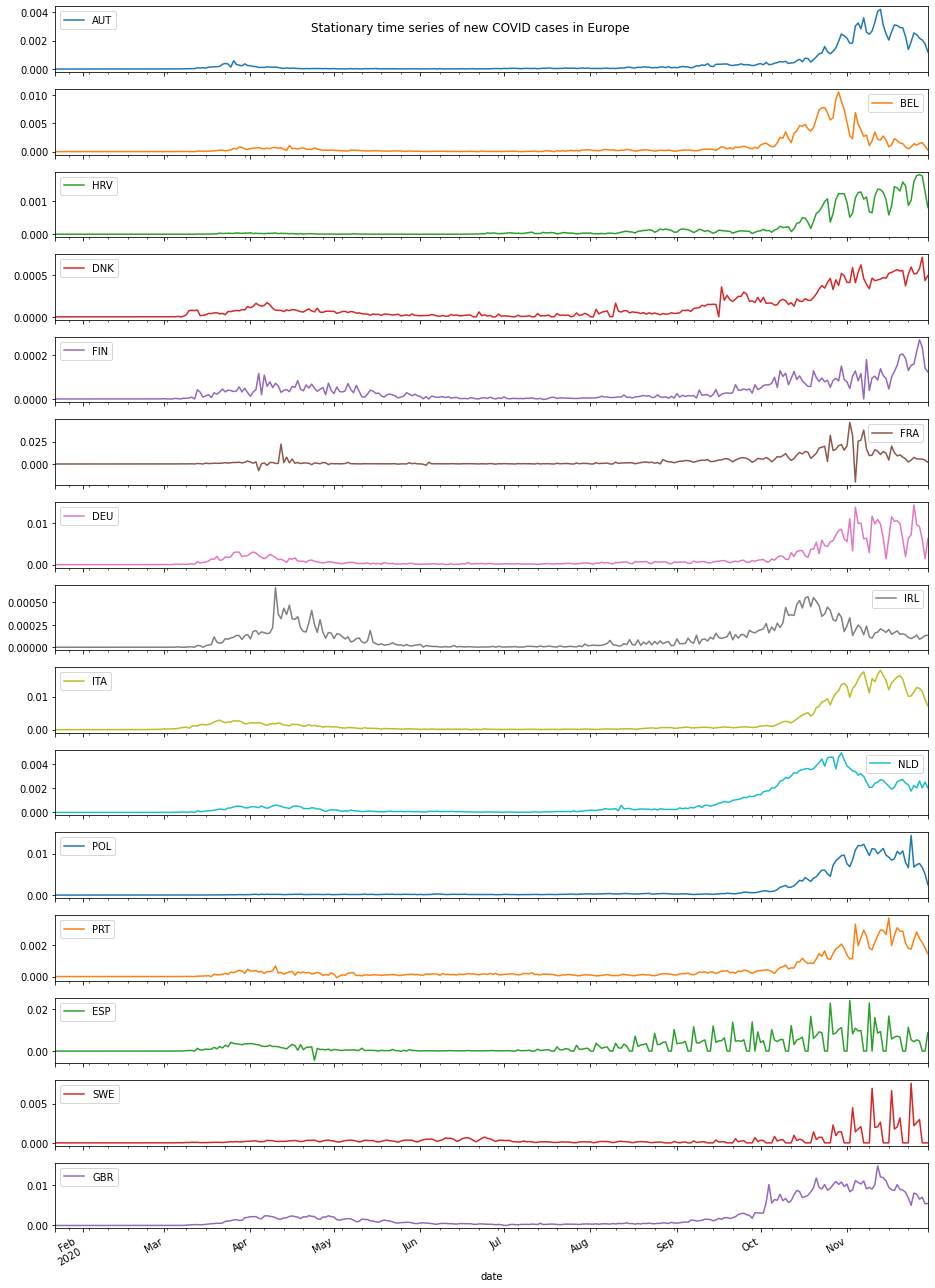


GRANGER CAUSALITY MATRIX: 



,AUT_x,BEL_x,HRV_x,DNK_x,FIN_x,FRA_x,DEU_x,IRL_x,ITA_x,NLD_x,POL_x,PRT_x,ESP_x,SWE_x,GBR_x
AUT_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BEL_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HRV_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DNK_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FIN_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FRA_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DEU_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IRL_y,0.0,0.0,0.0,0.0,0.0,0.0,0.175,0.0,0.0,0.0,0.224,0.283,0.139,0.161,0.0
ITA_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NLD_y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


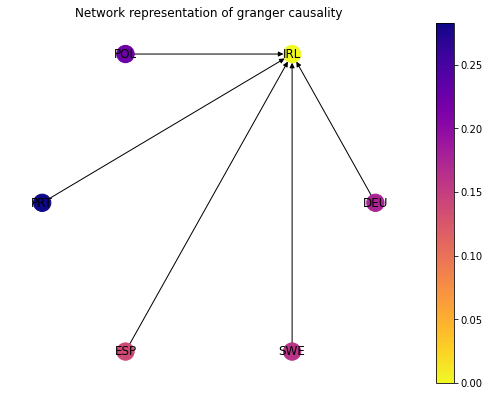

In [ ]:
granger_matrix_eu = granger_causality(df_confirmed_scaled_eu, countries_of_interest_eu, 'new COVID cases in Europe')

# Granger Causality 4 countries of interest

In [ ]:
endpoint = "https://covidapi.info/api/v1" # endpoint that provides JHU data
start_date = "2020-01-1"
end_date = "2020-12-01" # yesterday
dfs = {} # dfs of cumulative confirmed cases
for country in countries_of_interest:

    # re-download only data for country still not seen
    if os.path.isfile(f"data_covid/{country}.csv"):
        df = pd.read_csv(f"data_covid/{country}.csv")
    else:
        query = f"{endpoint}/country/{country}/timeseries/{start_date}/{end_date}"
        res = requests.get(query).json()
        df = pd.DataFrame(res["result"])
        df.index = pd.DatetimeIndex(df["date"], tz="utc")
        df.drop(columns=["date"])
        df["date"] = pd.to_datetime(df["date"])
        df["ts_in_secs"] = df["date"].astype(int)
        df["new_confirmed"] = df["confirmed"].diff().fillna(0)
        df.to_csv(f"{root}/{country}.csv")
        #df.to_csv(f"data_covid/{country}.csv")
        
    dfs[country] = df

## Analysis

In [ ]:
# dataset for confirmed cases for each country (needed later)
df_confirmed = pd.DataFrame(index = dfs[country].index)
df_total = pd.DataFrame(index = dfs[country].index)

In [ ]:
# first overview
for country,df in dfs.items():  
    df_confirmed[country] = df["new_confirmed"] 
    df_total[country] = df["confirmed"]

## Study New Cases

Normalize data

In [ ]:
df_confirmed_scaled = scale_data(df_confirmed, countries_of_interest)
df_confirmed_scaled.head()

,USA,CHE,JPN,CHN
date,,,,
2020-01-22 00:00:00+00:00,0.000000,0.0,0.00000,0.000000
2020-01-23 00:00:00+00:00,0.000000,0.0,0.00000,0.000465
2020-01-24 00:00:00+00:00,0.000005,0.0,0.00000,0.001357
2020-01-25 00:00:00+00:00,0.000000,0.0,0.00000,0.002381
2020-01-26 00:00:00+00:00,0.000015,0.0,0.00001,0.003278


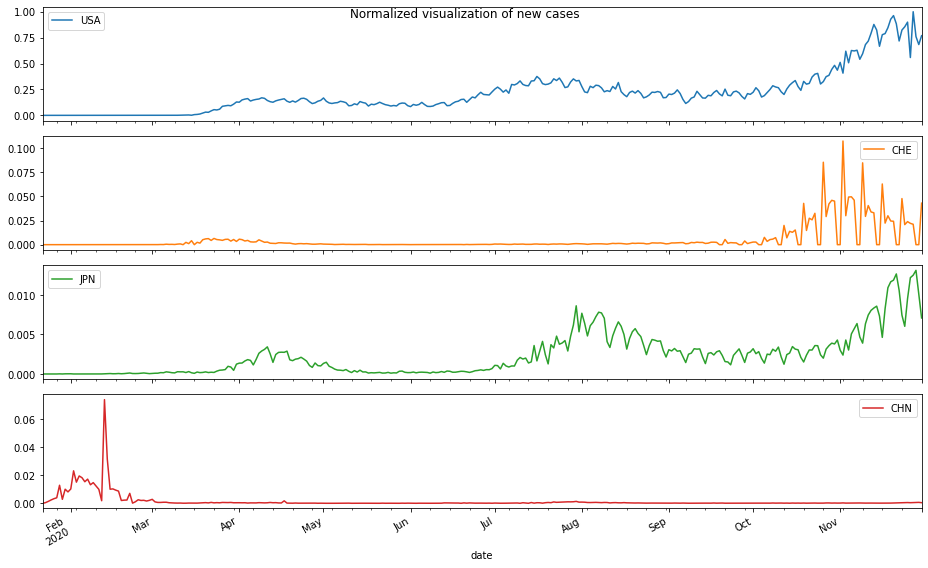

In [ ]:
plot_time_series(df_confirmed_scaled, 'Normalized visualization of new cases')

### Correlation matrix of new cases among different countries

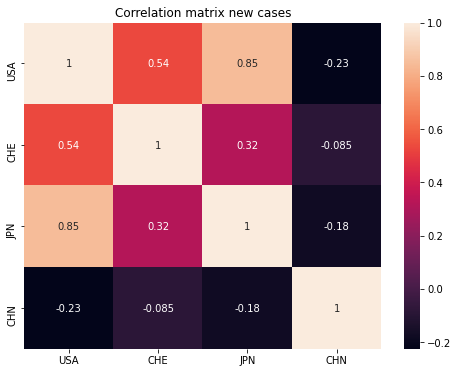

In [ ]:
plot_correlation_matrix(df_confirmed_scaled, countries_of_interest, 'Correlation matrix new cases')

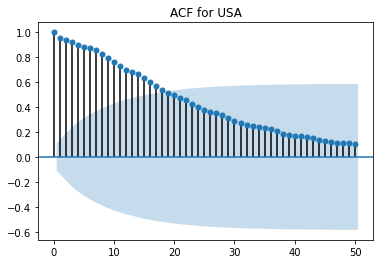

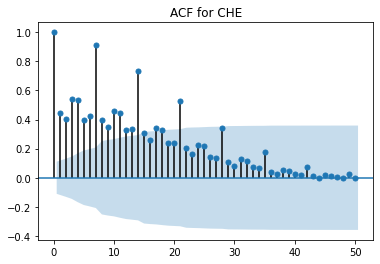

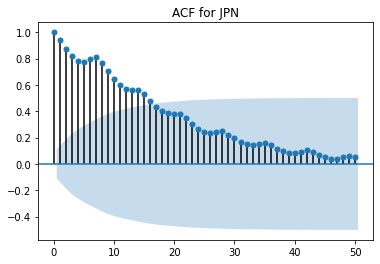

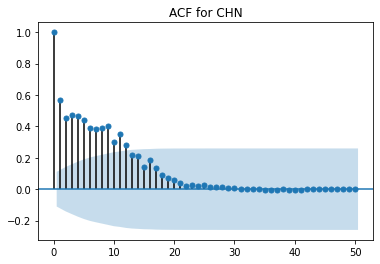

In [ ]:
for country in df_confirmed_scaled:
    sm.graphics.tsa.plot_acf(df_confirmed_scaled[country], lags = 50)
    plt.title('ACF for %s' % country)
    plt.show()

STATIONARY TEST: 

 Dickey-Fuller Stationary Test for "USA" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -1.6141
 No. Lags Chosen      = 15
 Critical value 1%     = -3.452
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.4758. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "CHE" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = -1.3911
 No. Lags Chosen      = 16
 Critical value 1%     = -3.453
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 0.5865. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "JPN" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics    

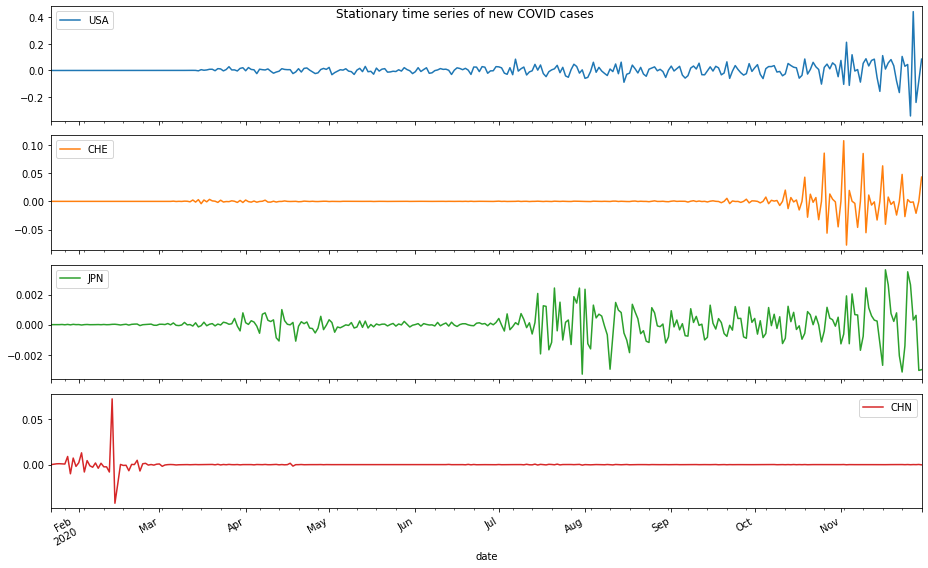


GRANGER CAUSALITY MATRIX: 



,USA_x,CHE_x,JPN_x,CHN_x
USA_y,0.0,0.0,0.0,0.991
CHE_y,0.0,0.0,0.0,0.986
JPN_y,0.0,0.0,0.0,0.978
CHN_y,0.996,0.988,0.986,0.0


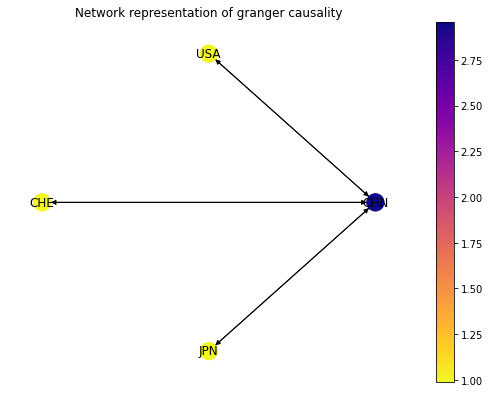

In [ ]:
granger_matrix = granger_causality(df_confirmed_scaled, countries_of_interest, 'new COVID cases')

## Study Total Cases

Normalize data

In [ ]:
df_total_scaled = scale_data(df_total, countries_of_interest)
df_total_scaled.head()

,USA,CHE,JPN,CHN
date,,,,
2020-01-22 00:00:00+00:00,7.353214e-08,0.0,1.470643e-07,0.000040
2020-01-23 00:00:00+00:00,7.353214e-08,0.0,1.470643e-07,0.000047
2020-01-24 00:00:00+00:00,1.470643e-07,0.0,1.470643e-07,0.000068
2020-01-25 00:00:00+00:00,1.470643e-07,0.0,1.470643e-07,0.000103
2020-01-26 00:00:00+00:00,3.676607e-07,0.0,2.941285e-07,0.000153


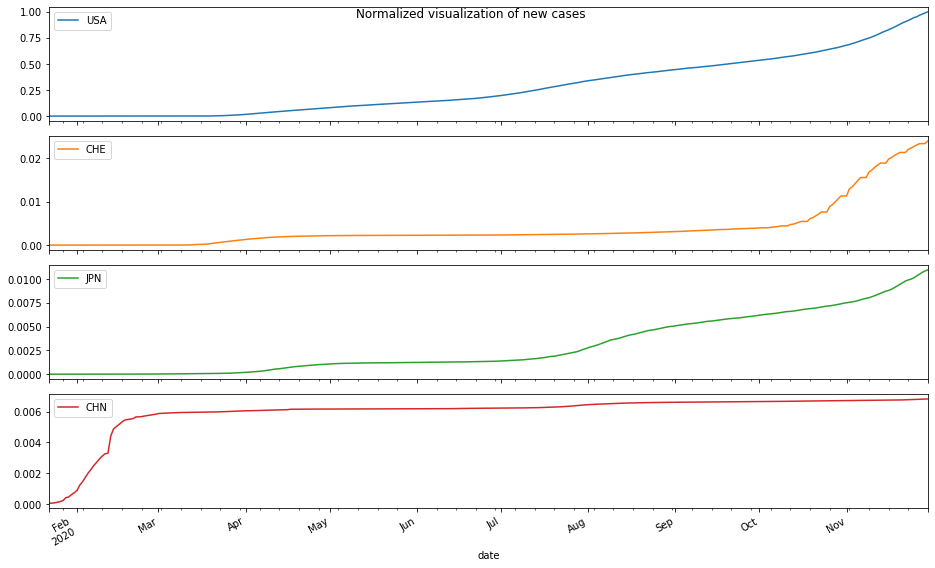

In [ ]:
plot_time_series(df_total_scaled, 'Normalized visualization of new cases')

### Correlation matrix of new cases among different countries

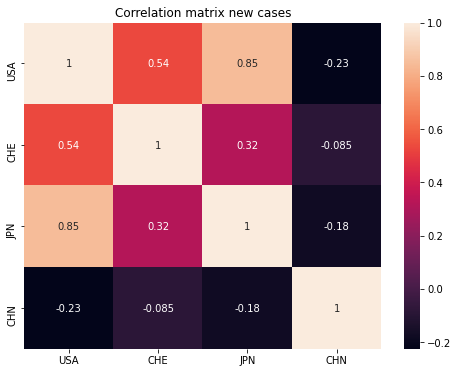

In [ ]:
plot_correlation_matrix(df_confirmed_scaled, countries_of_interest, 'Correlation matrix new cases')

### Auto Correlation

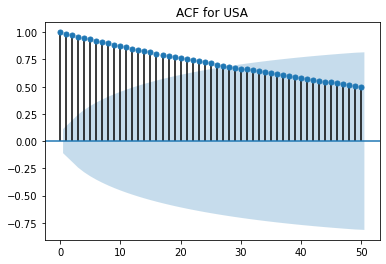

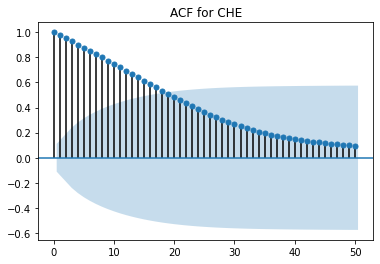

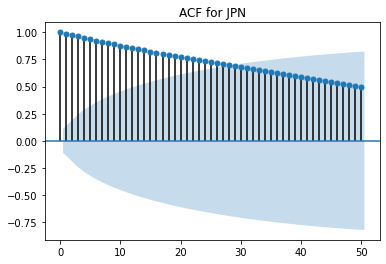

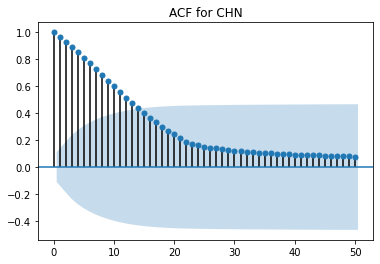

In [ ]:
for country in df_total_scaled:
    sm.graphics.tsa.plot_acf(df_total_scaled[country], lags = 50)
    plt.title('ACF for %s' % country)
    plt.show()

STATIONARY TEST: 

 Dickey-Fuller Stationary Test for "USA" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = 3.2176
 No. Lags Chosen      = 16
 Critical value 1%     = -3.453
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 1.0. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "CHE" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = 4.5934
 No. Lags Chosen      = 15
 Critical value 1%     = -3.452
 Critical value 5%     = -2.871
 Critical value 10%    = -2.572
 => P-Value = 1.0. Weak evidence to reject H0.
 => Series in Non-Stationary


 Dickey-Fuller Stationary Test for "JPN" 
 -----------------------------------------------
 Null Hypothesis: Data are Non-Stationary.
 Significance level   = 0.05
 Test Statistics      = 2.87

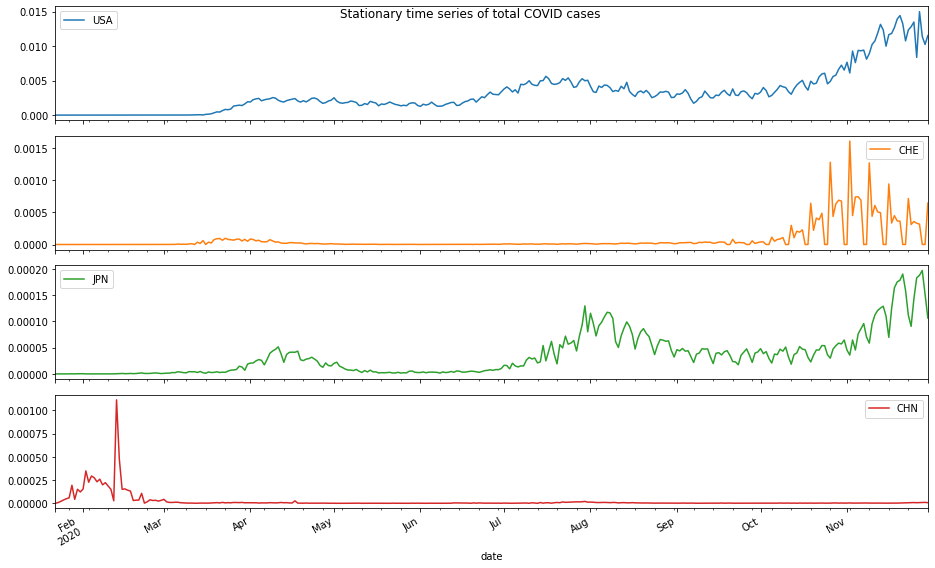


GRANGER CAUSALITY MATRIX: 



,USA_x,CHE_x,JPN_x,CHN_x
USA_y,0.0,0.0,0.0,0.568
CHE_y,0.0,0.0,0.0,0.347
JPN_y,0.0,0.0,0.0,0.57
CHN_y,0.0,0.423,0.0,0.0


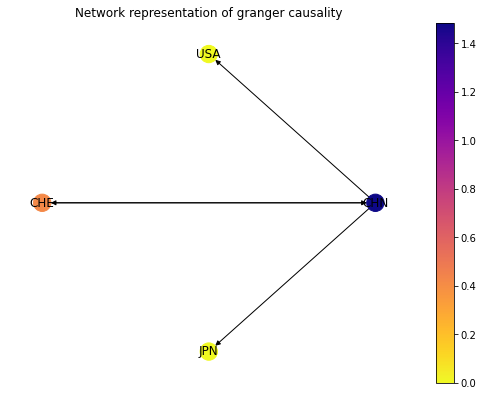

In [ ]:
granger_matrix = granger_causality(df_total_scaled, countries_of_interest, 'total COVID cases')